<h1>Geometry of Sliding Window Embeddings</h1><BR>
In this module, you will interactively explore how various parameters of sliding window embeddings of 1 dimensional periodic time series data affects the geometry of their embeddings.  Click the play button on the boxes one at a time in order to progress through the module.  This first box imports all of the necessary Python packages to run the code in this module, and there will be a similar box at the beginning of every module in this series.

In [12]:
#Do all of the imports and setup inline plotting
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import scipy.interpolate as interp

from TDA import *

<h1>Pure Sinusoid Sliding Window</h1><BR>
In this first experiment, you will alter the extent of the sliding window of a pure sinusoid and examine how the geometry changes.  First, setup and plot a pure sinusoid in numpy

<IPython.core.display.Javascript object>


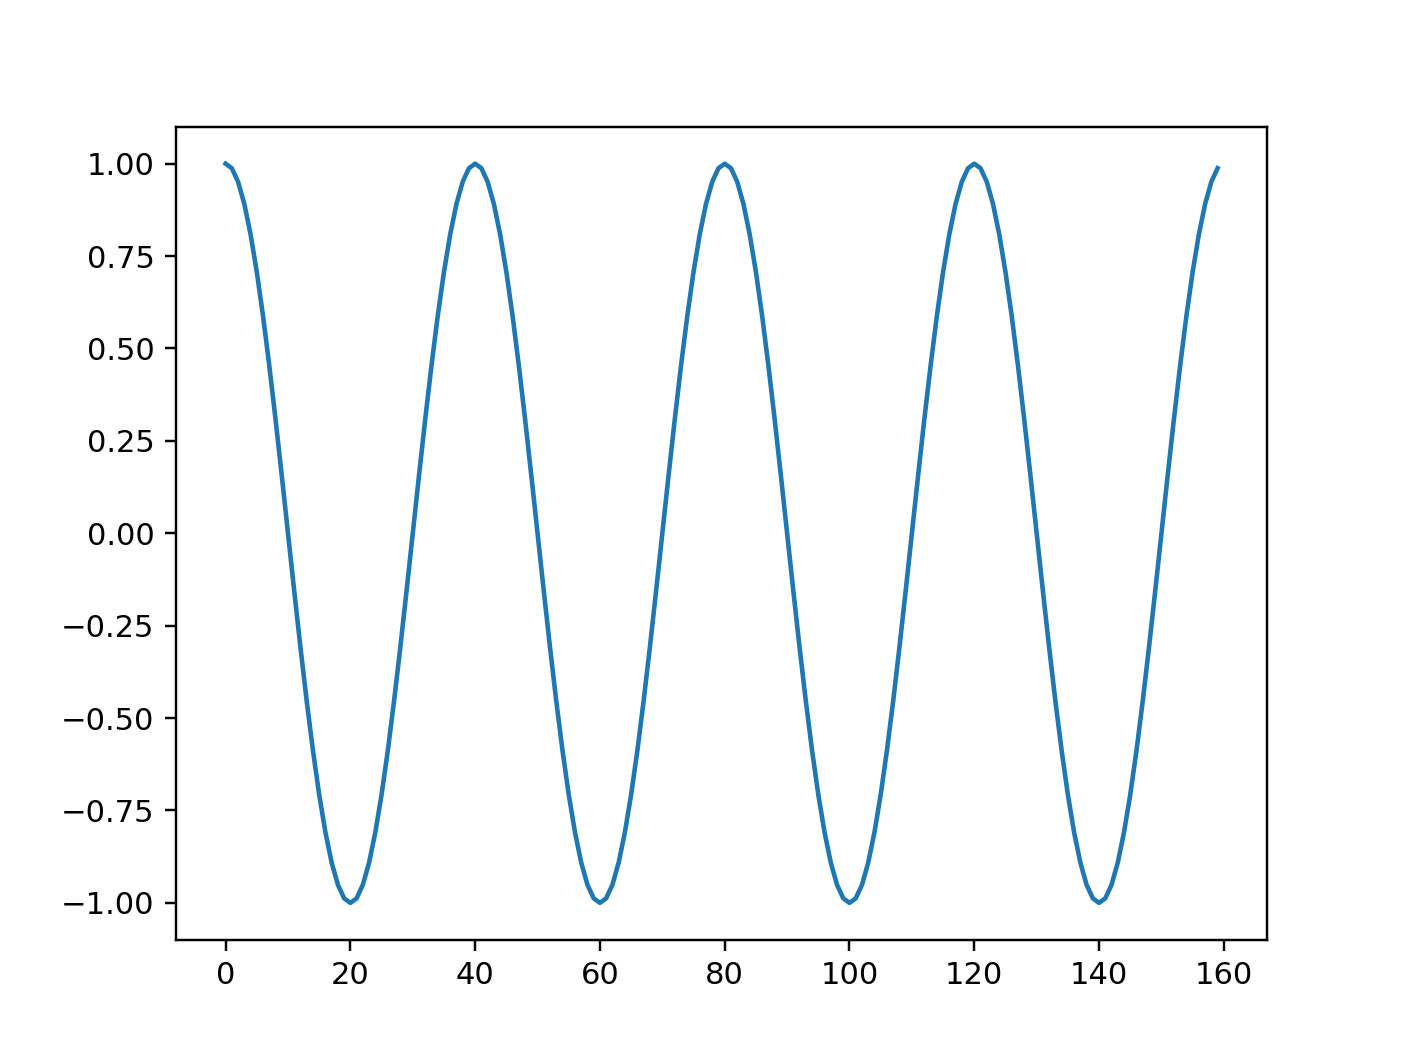

In [13]:
#Step 1: Setup the signal
T = 40 #The period in number of samples
NPeriods = 4 #How many periods to go through
N = T*NPeriods #The total number of samples
t = np.linspace(0, 2*np.pi*NPeriods, N+1)[0:N] #Sampling indices in time
x = np.cos(t) #The final signal
plt.plot(x)

<h2>Sliding Window Code</h2><BR>
The code below performs a sliding window embedding on a 1D signal.  The parameters are as follows:
<table>
<tr><td>$$x$$</td><td>The 1D signal (numpy array)</td></tr>
<tr><td><code>dim</code></td><td>The dimension of the embedding</td></tr>
<tr><td>$$\tau$$</td><td>The amount to skip between each delay</td></tr>
<tr><td><code>dT</code></td><td>The time interval between each sliding window sample</td></tr>
</table><BR>
Spline interpolation is used to fill in information between signal samples, which is necessary for certain combinations of parameters, such as a non-integer Tau or dT.

In [14]:
def getSlidingWindow(x, dim, Tau, dT):
    N = len(x)
    NWindows = int(np.floor((N-dim*Tau)/dT)) #The number of windows
    if NWindows <= 0:
        print("Error: Tau too large for signal extent")
        return np.zeros((3, dim))
    X = np.zeros((NWindows, dim)) #Create a 2D array which will store all windows
    idx = np.arange(N)
    for i in range(NWindows):
        #Figure out the indices of the samples in this window
        idxx = dT*i + Tau*np.arange(dim) 
        start = int(np.floor(idxx[0]))
        end = int(np.ceil(idxx[-1]))+2
        if end >= len(x):
            X = X[0:i, :]
            break
        #Do spline interpolation to fill in this window, and place
        #it in the resulting array
        X[i, :] = interp.spline(idx[start:end+1], x[start:end+1], idxx)
    return X

<h2>Sliding Window Result</h2><BR>
We will now perform a sliding window embedding with various choices of parameters.  <a href = "https://en.wikipedia.org/wiki/Principal_component_analysis">Principal component analysis</a> will be performed to project the result down to 2D for visualization.  When the code runs, it will print the first two eigenvalues of PCA.  The closer these eigenvalues are to each other, the rounder and more close to a circle the embedding is.  You should play around with the parameters of the sliding window embedding and examine the result.  A red vertical line will be drawn to show the product of Tau and the dimension, or "extent" (window length)



lambda1 = 4.97031
lambda2 = 4.94629




<IPython.core.display.Javascript object>


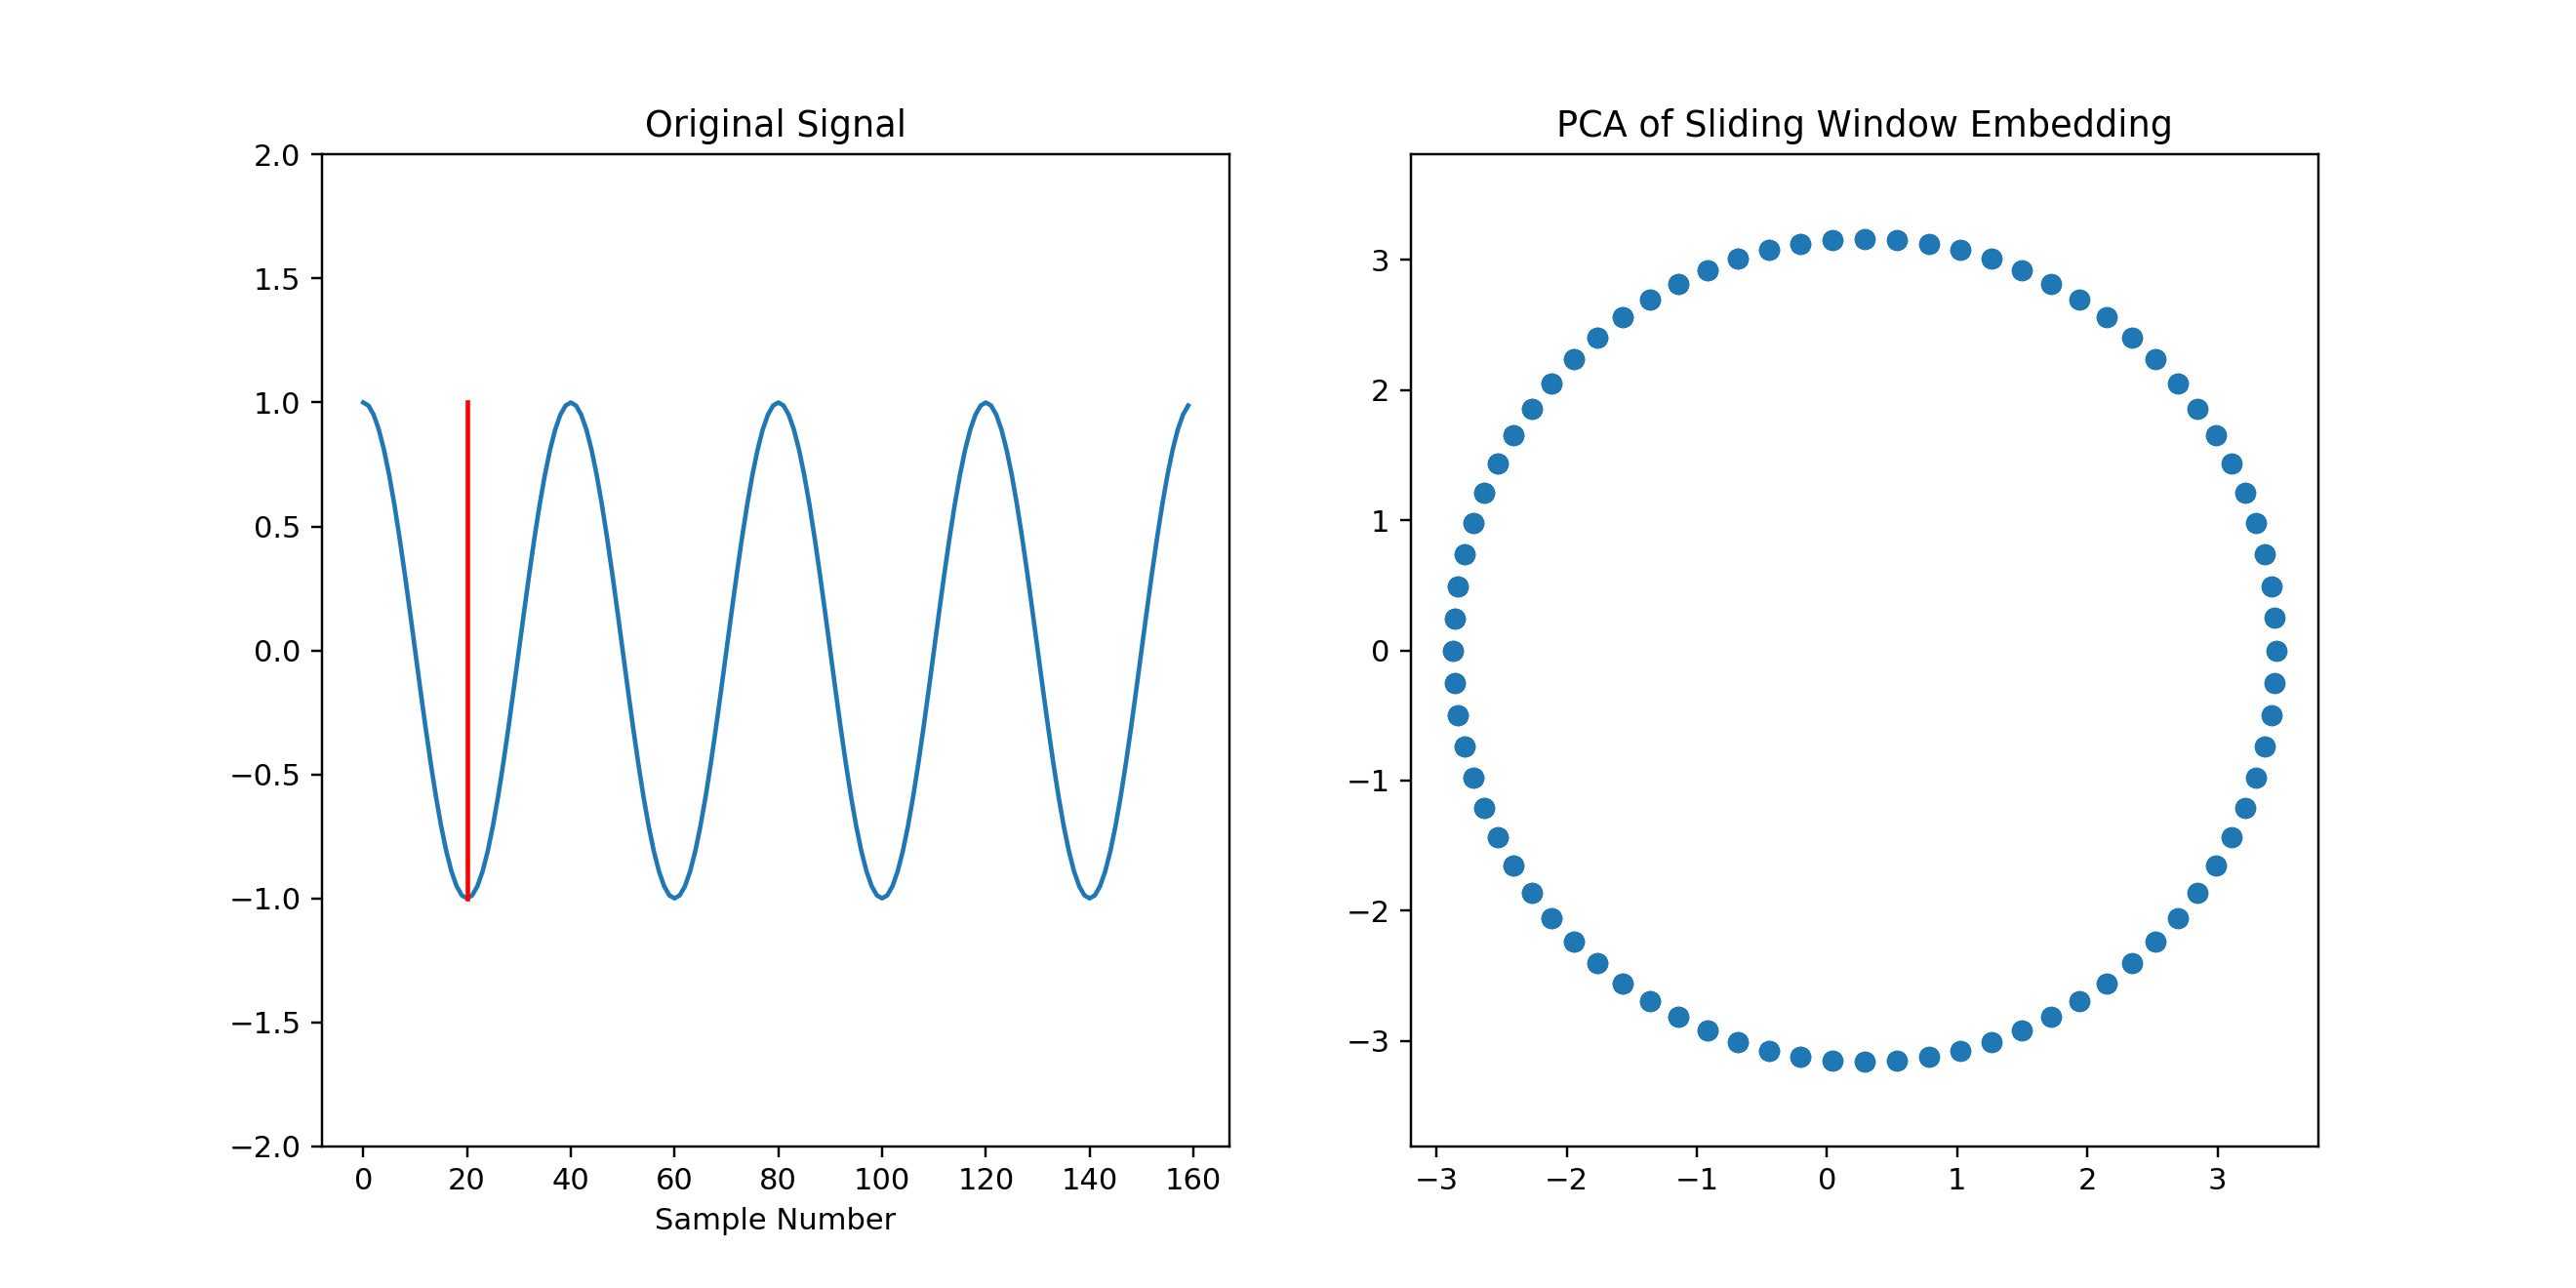

<IPython.core.display.Javascript object>


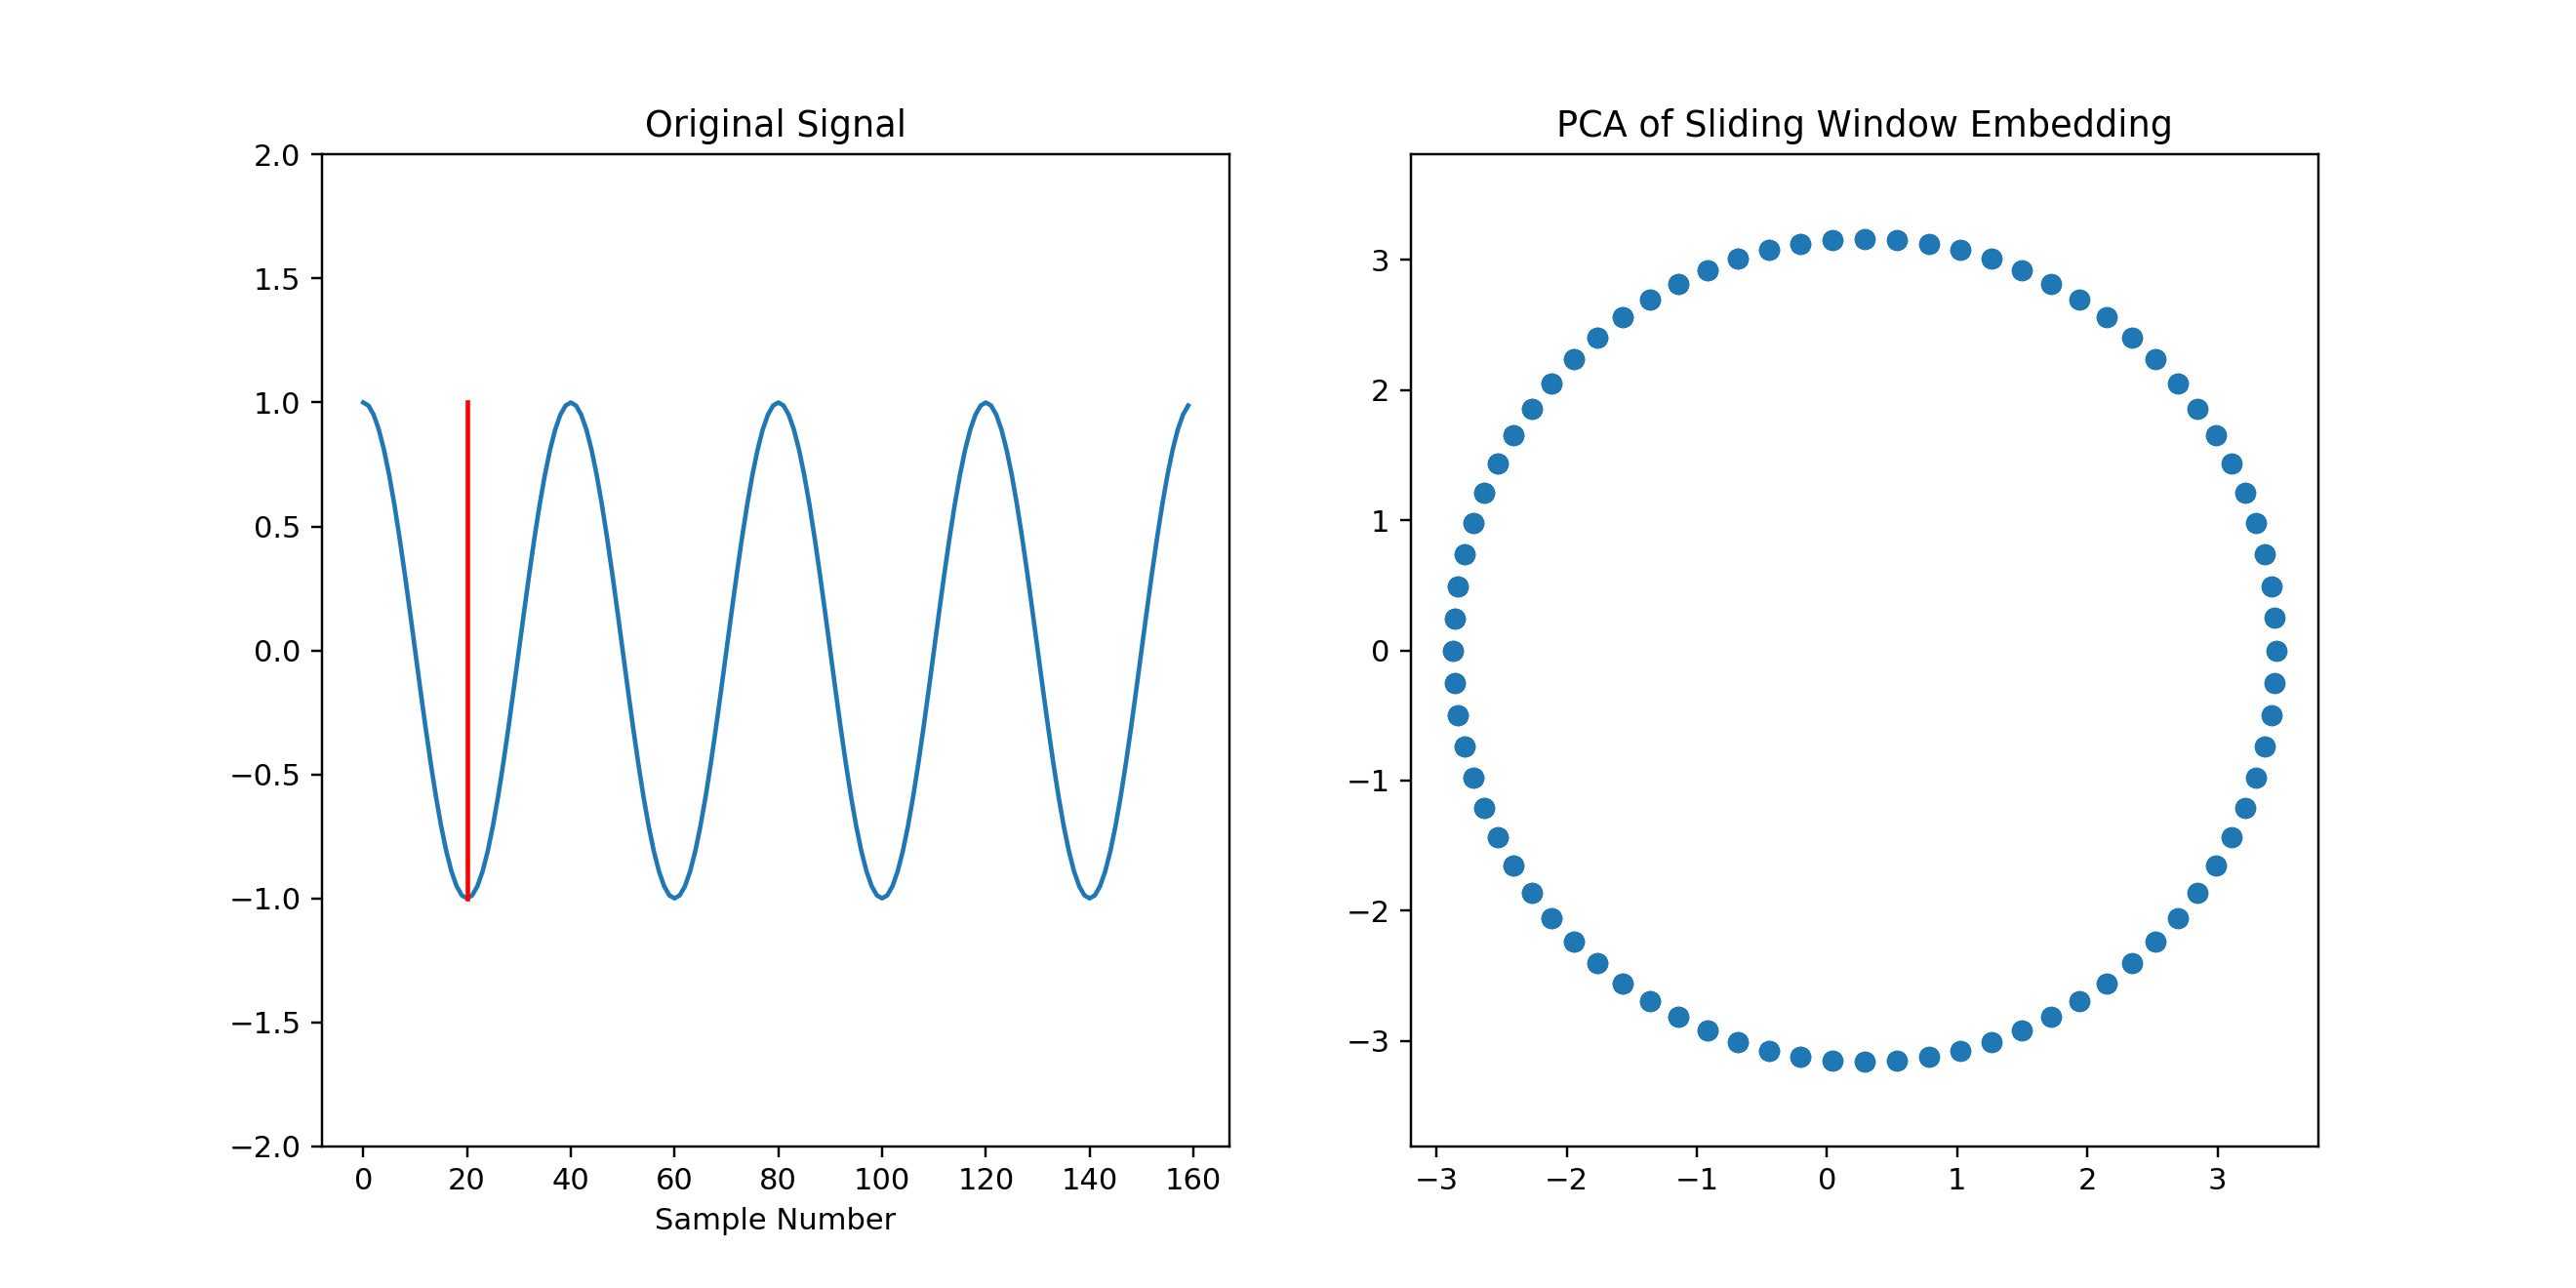

(-2, 2)

In [15]:
#Step 2: Do a sliding window embedding
dim = 20
Tau = 1
dT = 0.5
X = getSlidingWindow(x, dim, Tau, dT)
extent = Tau*dim

#Step 3: Perform PCA down to 2D for visualization
pca = PCA(n_components = 2)
Y = pca.fit_transform(X)
eigs = pca.explained_variance_
print("\n\nlambda1 = %g\nlambda2 = %g\n\n"%(eigs[0], eigs[1]))

#Step 4: Plot original signal and PCA of the embedding
plt.figure(figsize=(12, 6))
ax = plt.subplot(121)
ax.plot(x)
ax.set_ylim((-2, 2))
ax.set_title("Original Signal")
ax.set_xlabel("Sample Number")
#ax.hold(True)
ax.plot([extent, extent], [np.min(x), np.max(x)], 'r')
ax2 = plt.subplot(122)
ax2.set_title("PCA of Sliding Window Embedding")
ax2.scatter(Y[:, 0], Y[:, 1])
ax2.set_aspect('equal', 'datalim')
plt.show()

<h1>Non-Periodic Signal Sliding Window</h1><BR>
For a contrasting example, we will now examine the sliding window embedding of a non-periodic signal which is a ramp function plus Gaussian noise.  The code below sets up the signal and then does the sliding window embedding, as before.  But notice how changing the window extent doesn't have the same impact.  Why might this be?

lambda1 = 1.49421, lambda2 = 0.00306669


<IPython.core.display.Javascript object>


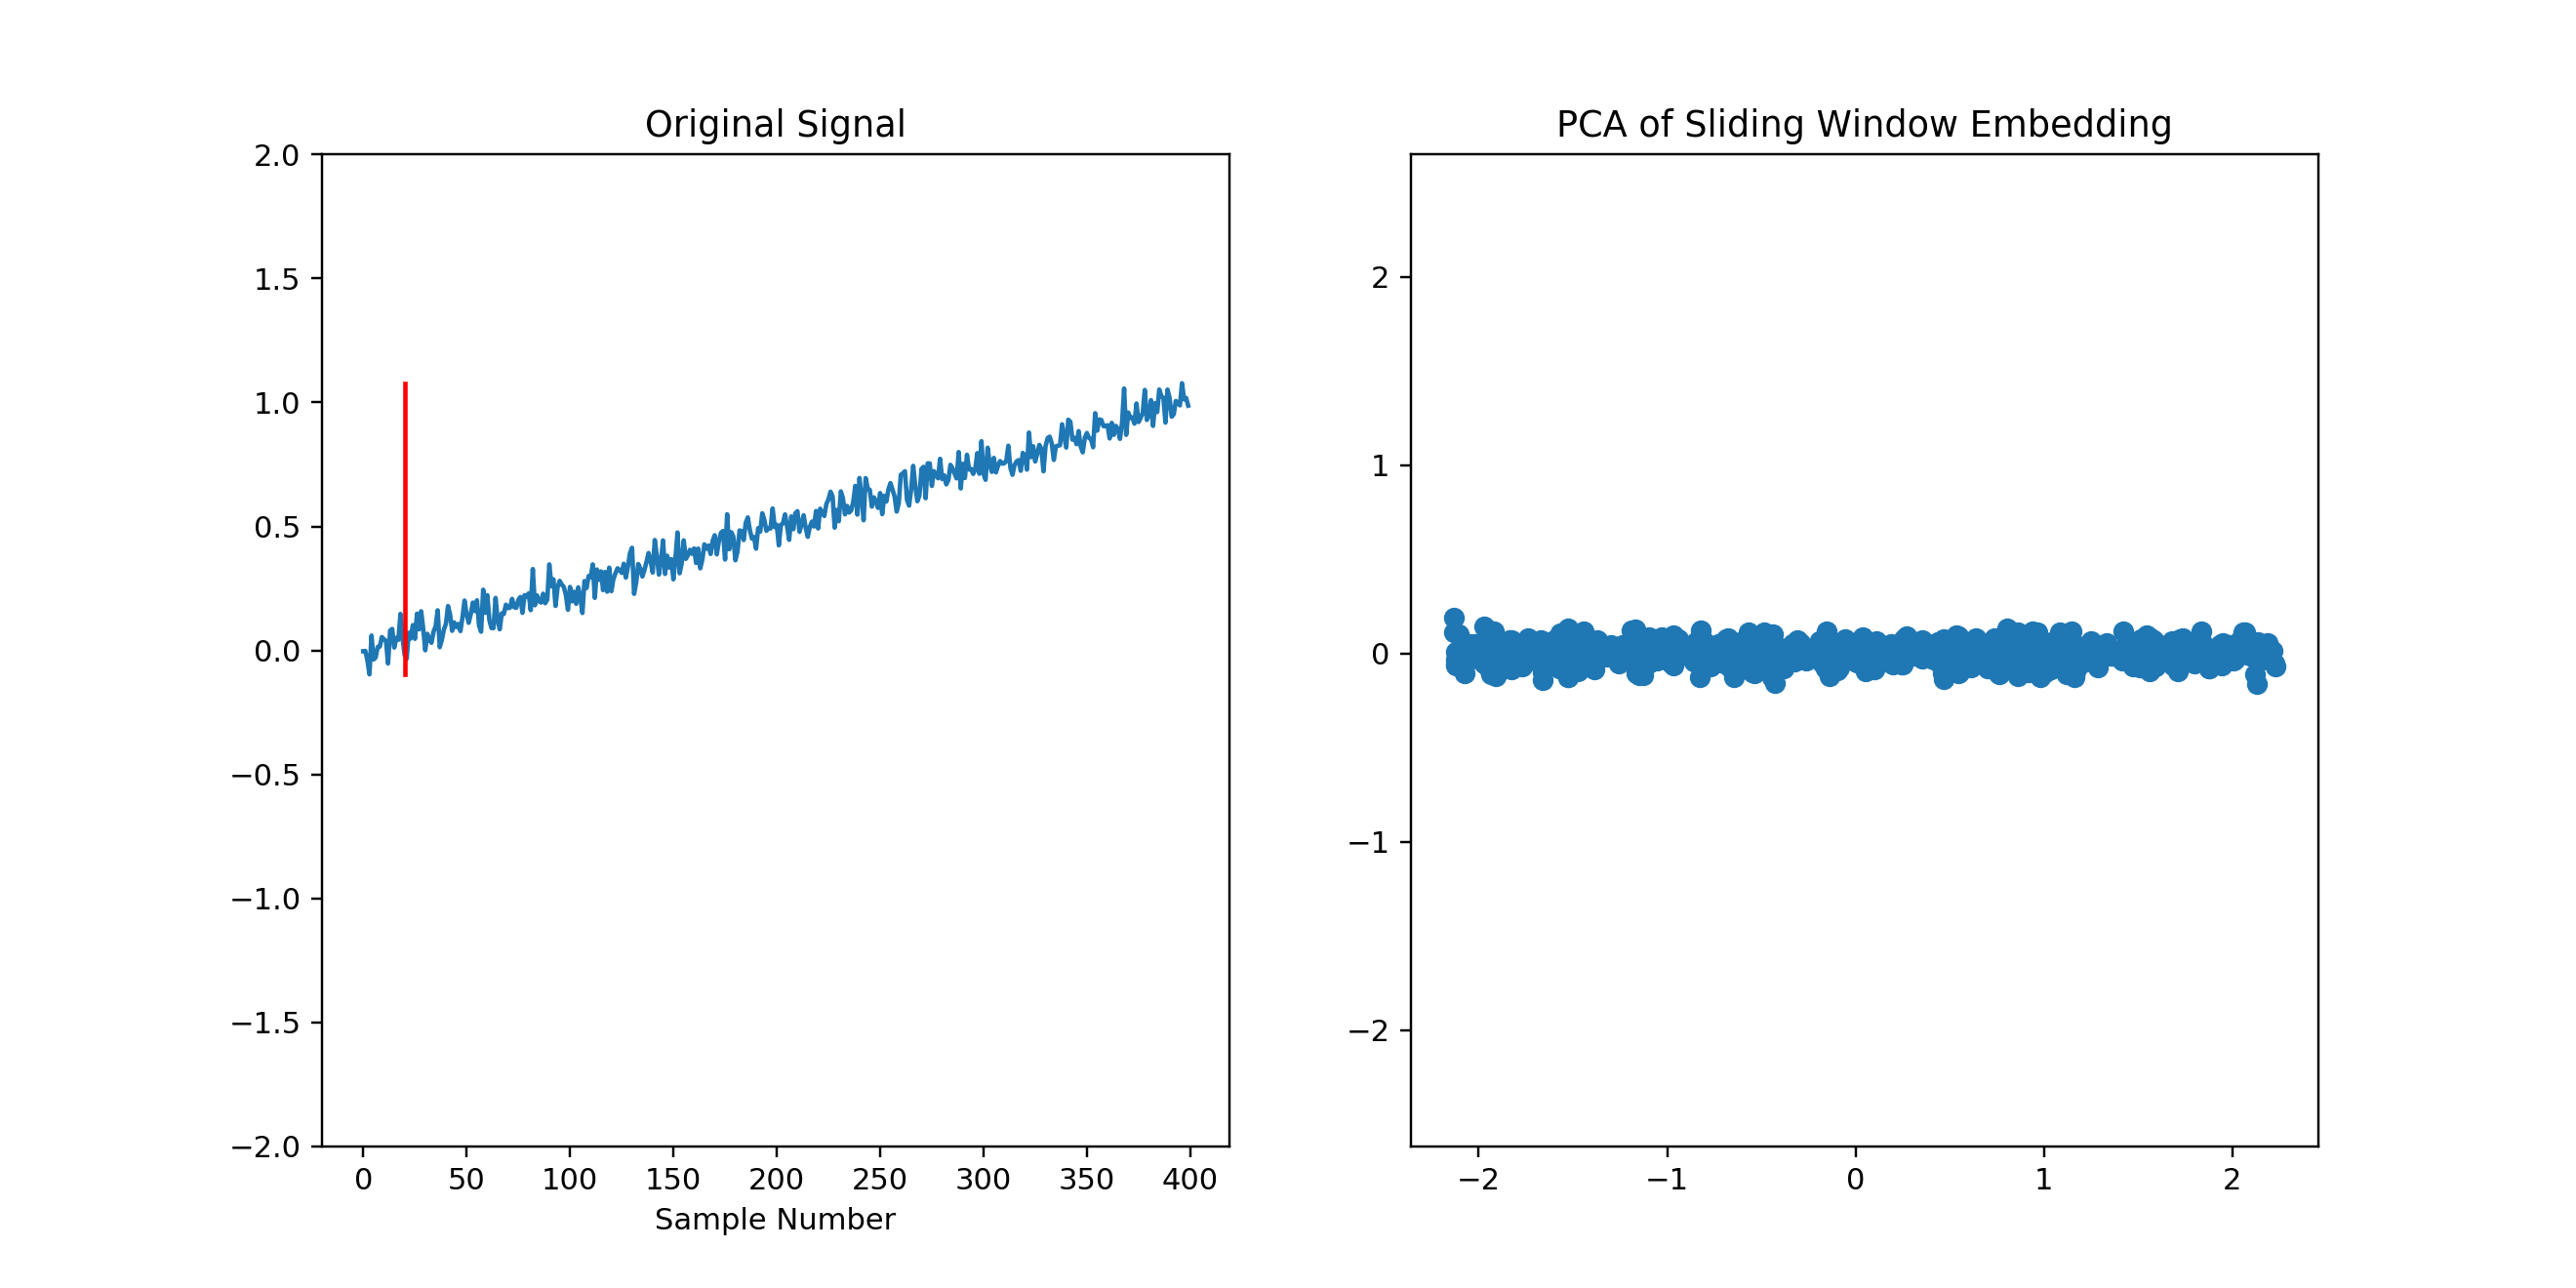

<IPython.core.display.Javascript object>


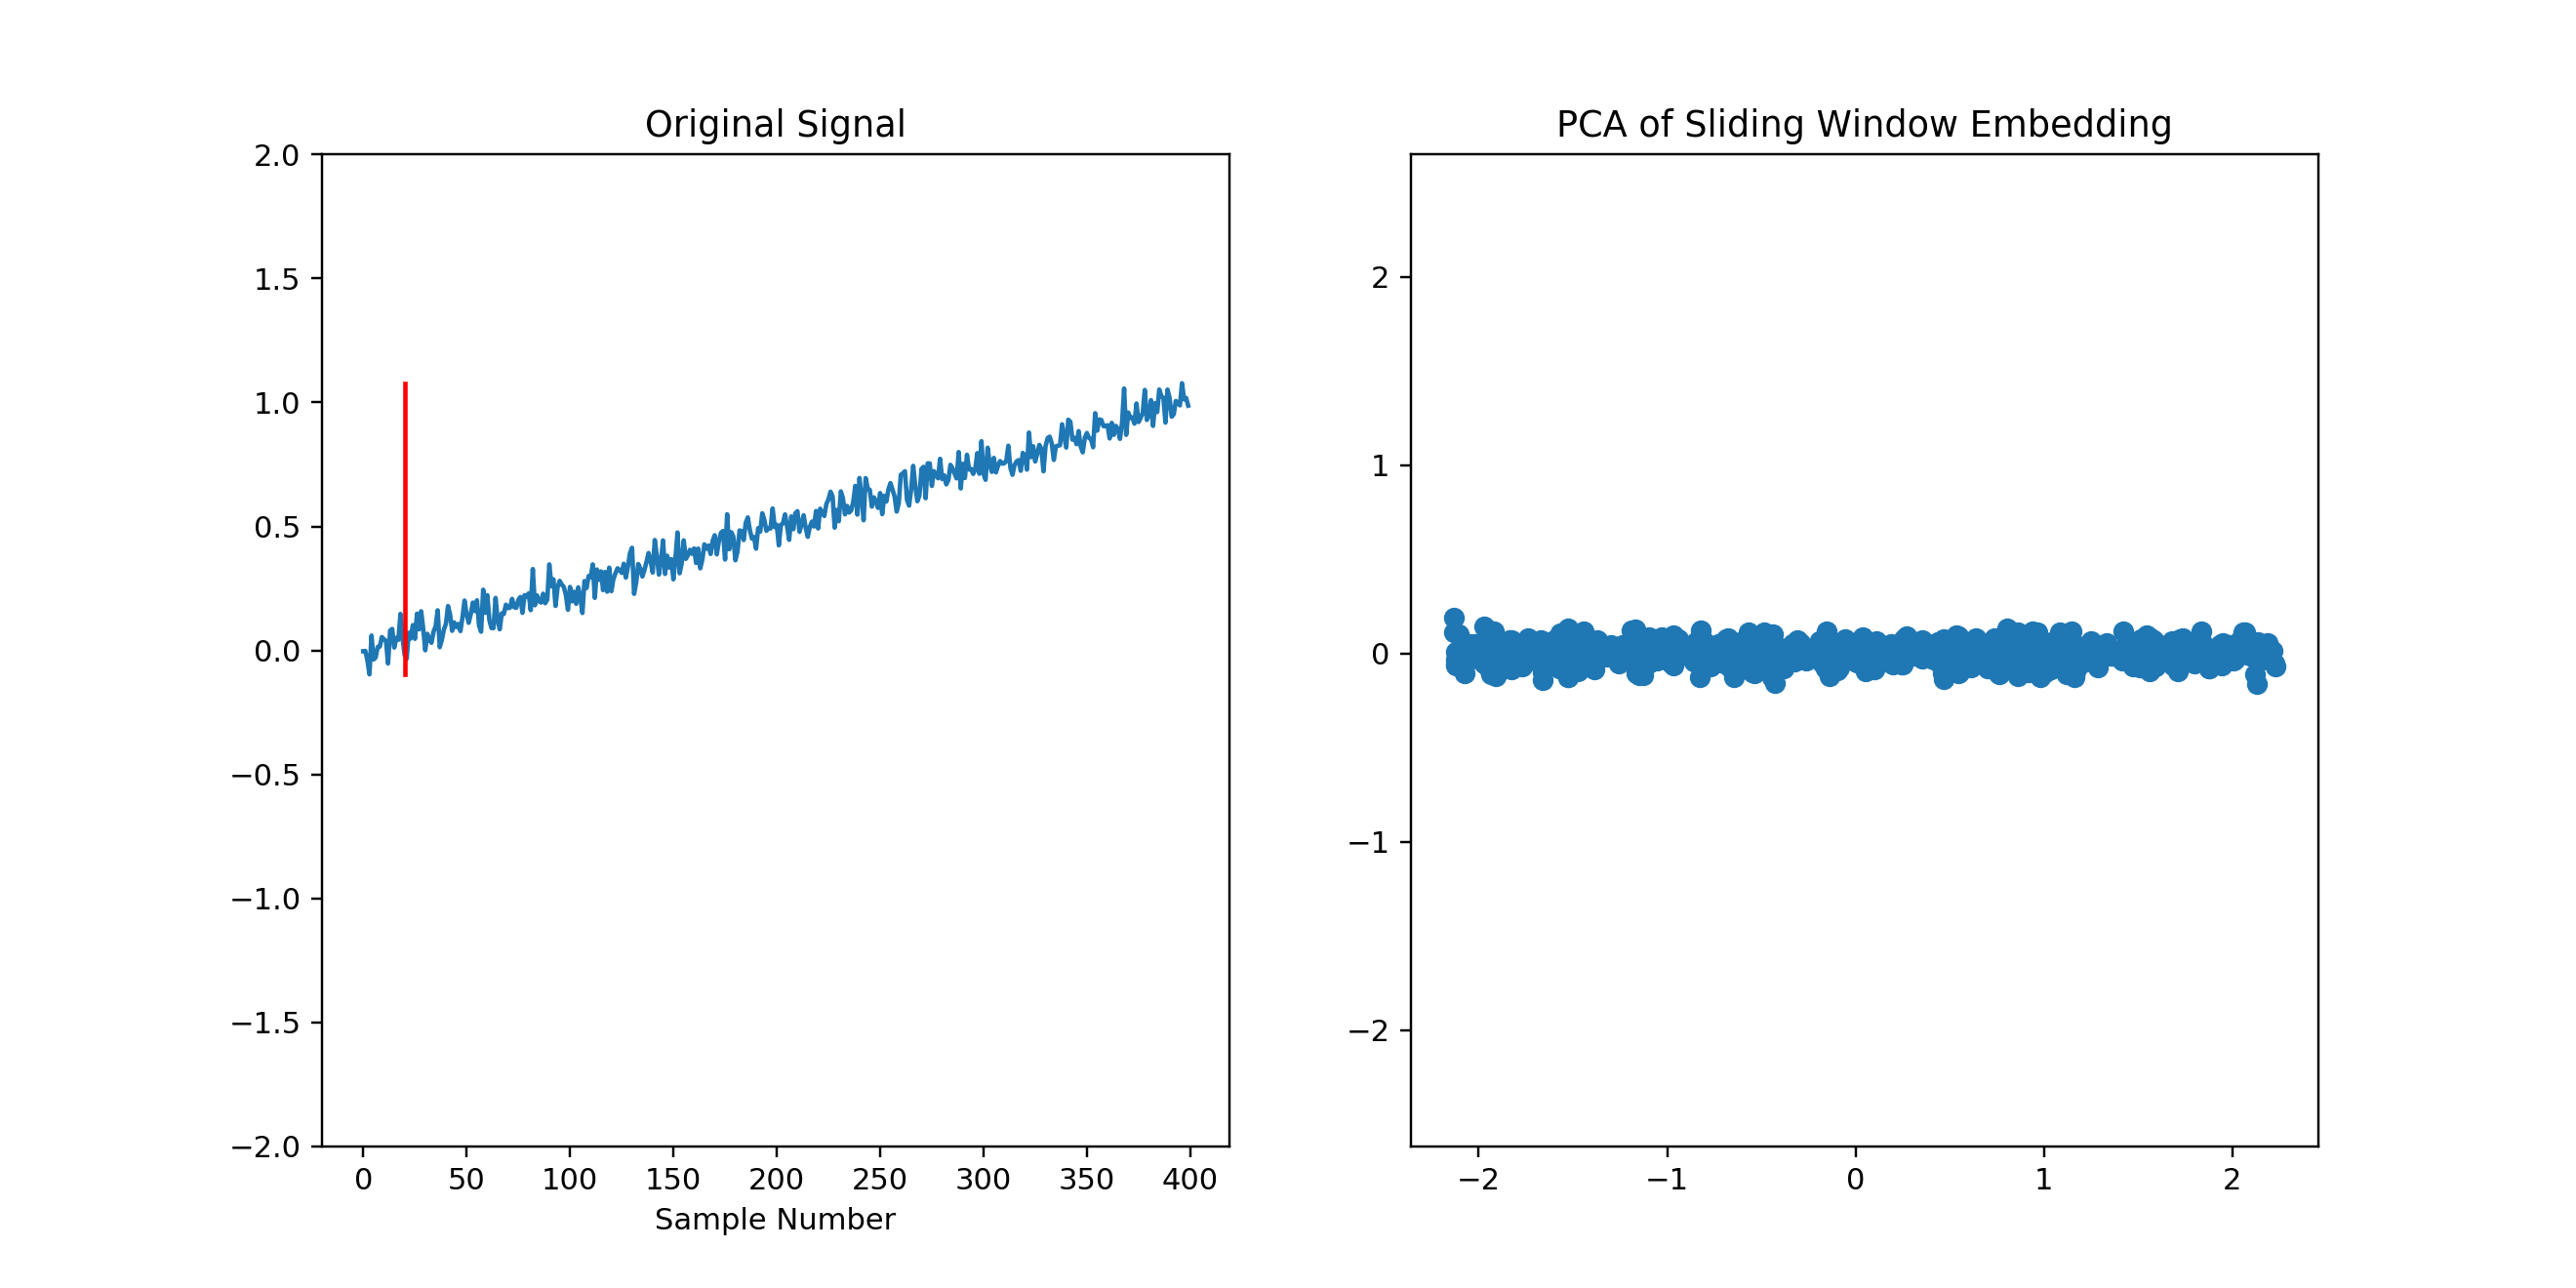

(-2, 2)

In [16]:
x = np.arange(400)
x = x/float(len(x))
x = x + 0.05*np.random.randn(len(x)) #Add some noise

#Step 2: Do a sliding window embedding
dim = 20
Tau = 1
dT = 0.5
X = getSlidingWindow(x, dim, Tau, dT)
extent = Tau*dim

#Step 3: Perform PCA down to 2D for visualization
pca = PCA(n_components = dim)
Y = pca.fit_transform(X)
eigs = pca.explained_variance_
print("lambda1 = %g, lambda2 = %g"%(eigs[0], eigs[1]))

#Step 4: Plot original signal and PCA of the embedding
plt.figure(figsize=(12, 6))
ax = plt.subplot(121)
ax.plot(x)
ax.set_ylim((-2, 2))
ax.set_title("Original Signal")
ax.set_xlabel("Sample Number")
#ax.hold(True)
ax.plot([extent, extent], [np.min(x), np.max(x)], 'r')
ax2 = plt.subplot(122)
ax2.set_title("PCA of Sliding Window Embedding")
ax2.scatter(Y[:, 0], Y[:, 1])
ax2.set_aspect('equal', 'datalim')
plt.show()

<h1>2 Sines Sliding Window</h1><BR>
We will now go back to periodic signals, but this time we will increase the complexity by adding two sines together.  If the ratio between the two sinusoids is a rational number, then they are called <i>harmonics</i> of each other.  By contrast, if the two frequencies are linearly independent over the rational numbers, then the sinusoids are called <i>incommensurate</i>.  The example below starts with 

$$f(t) = \sin(\omega t) + \sin(3\omega t)$$

which is an example of the harmonic case.  First generate the signal and then do the embedding, as above.  This time, the first 10 eigenvalues of PCA will be plotted, in addition to the red line showing the extent of the window.  Also, 3D PCA will be displayed instead of 2D PCA, and you can click and drag your mouse to view it from different angles.  Colors will be drawn to indicate the position of the window in time, with cool colors indicating earlier windows and hot colors indicating later windows (using the "jet" colormap).

<BR>In addition to varying the window size, do an example of both harmonic sinusoids and non-commensurate sinusoids.  What do the differences seem to be between the two cases?<BR>

<i>Hint: For the non-commensurate case, it might help to use the command</i> <code>np.pi</code>

<IPython.core.display.Javascript object>


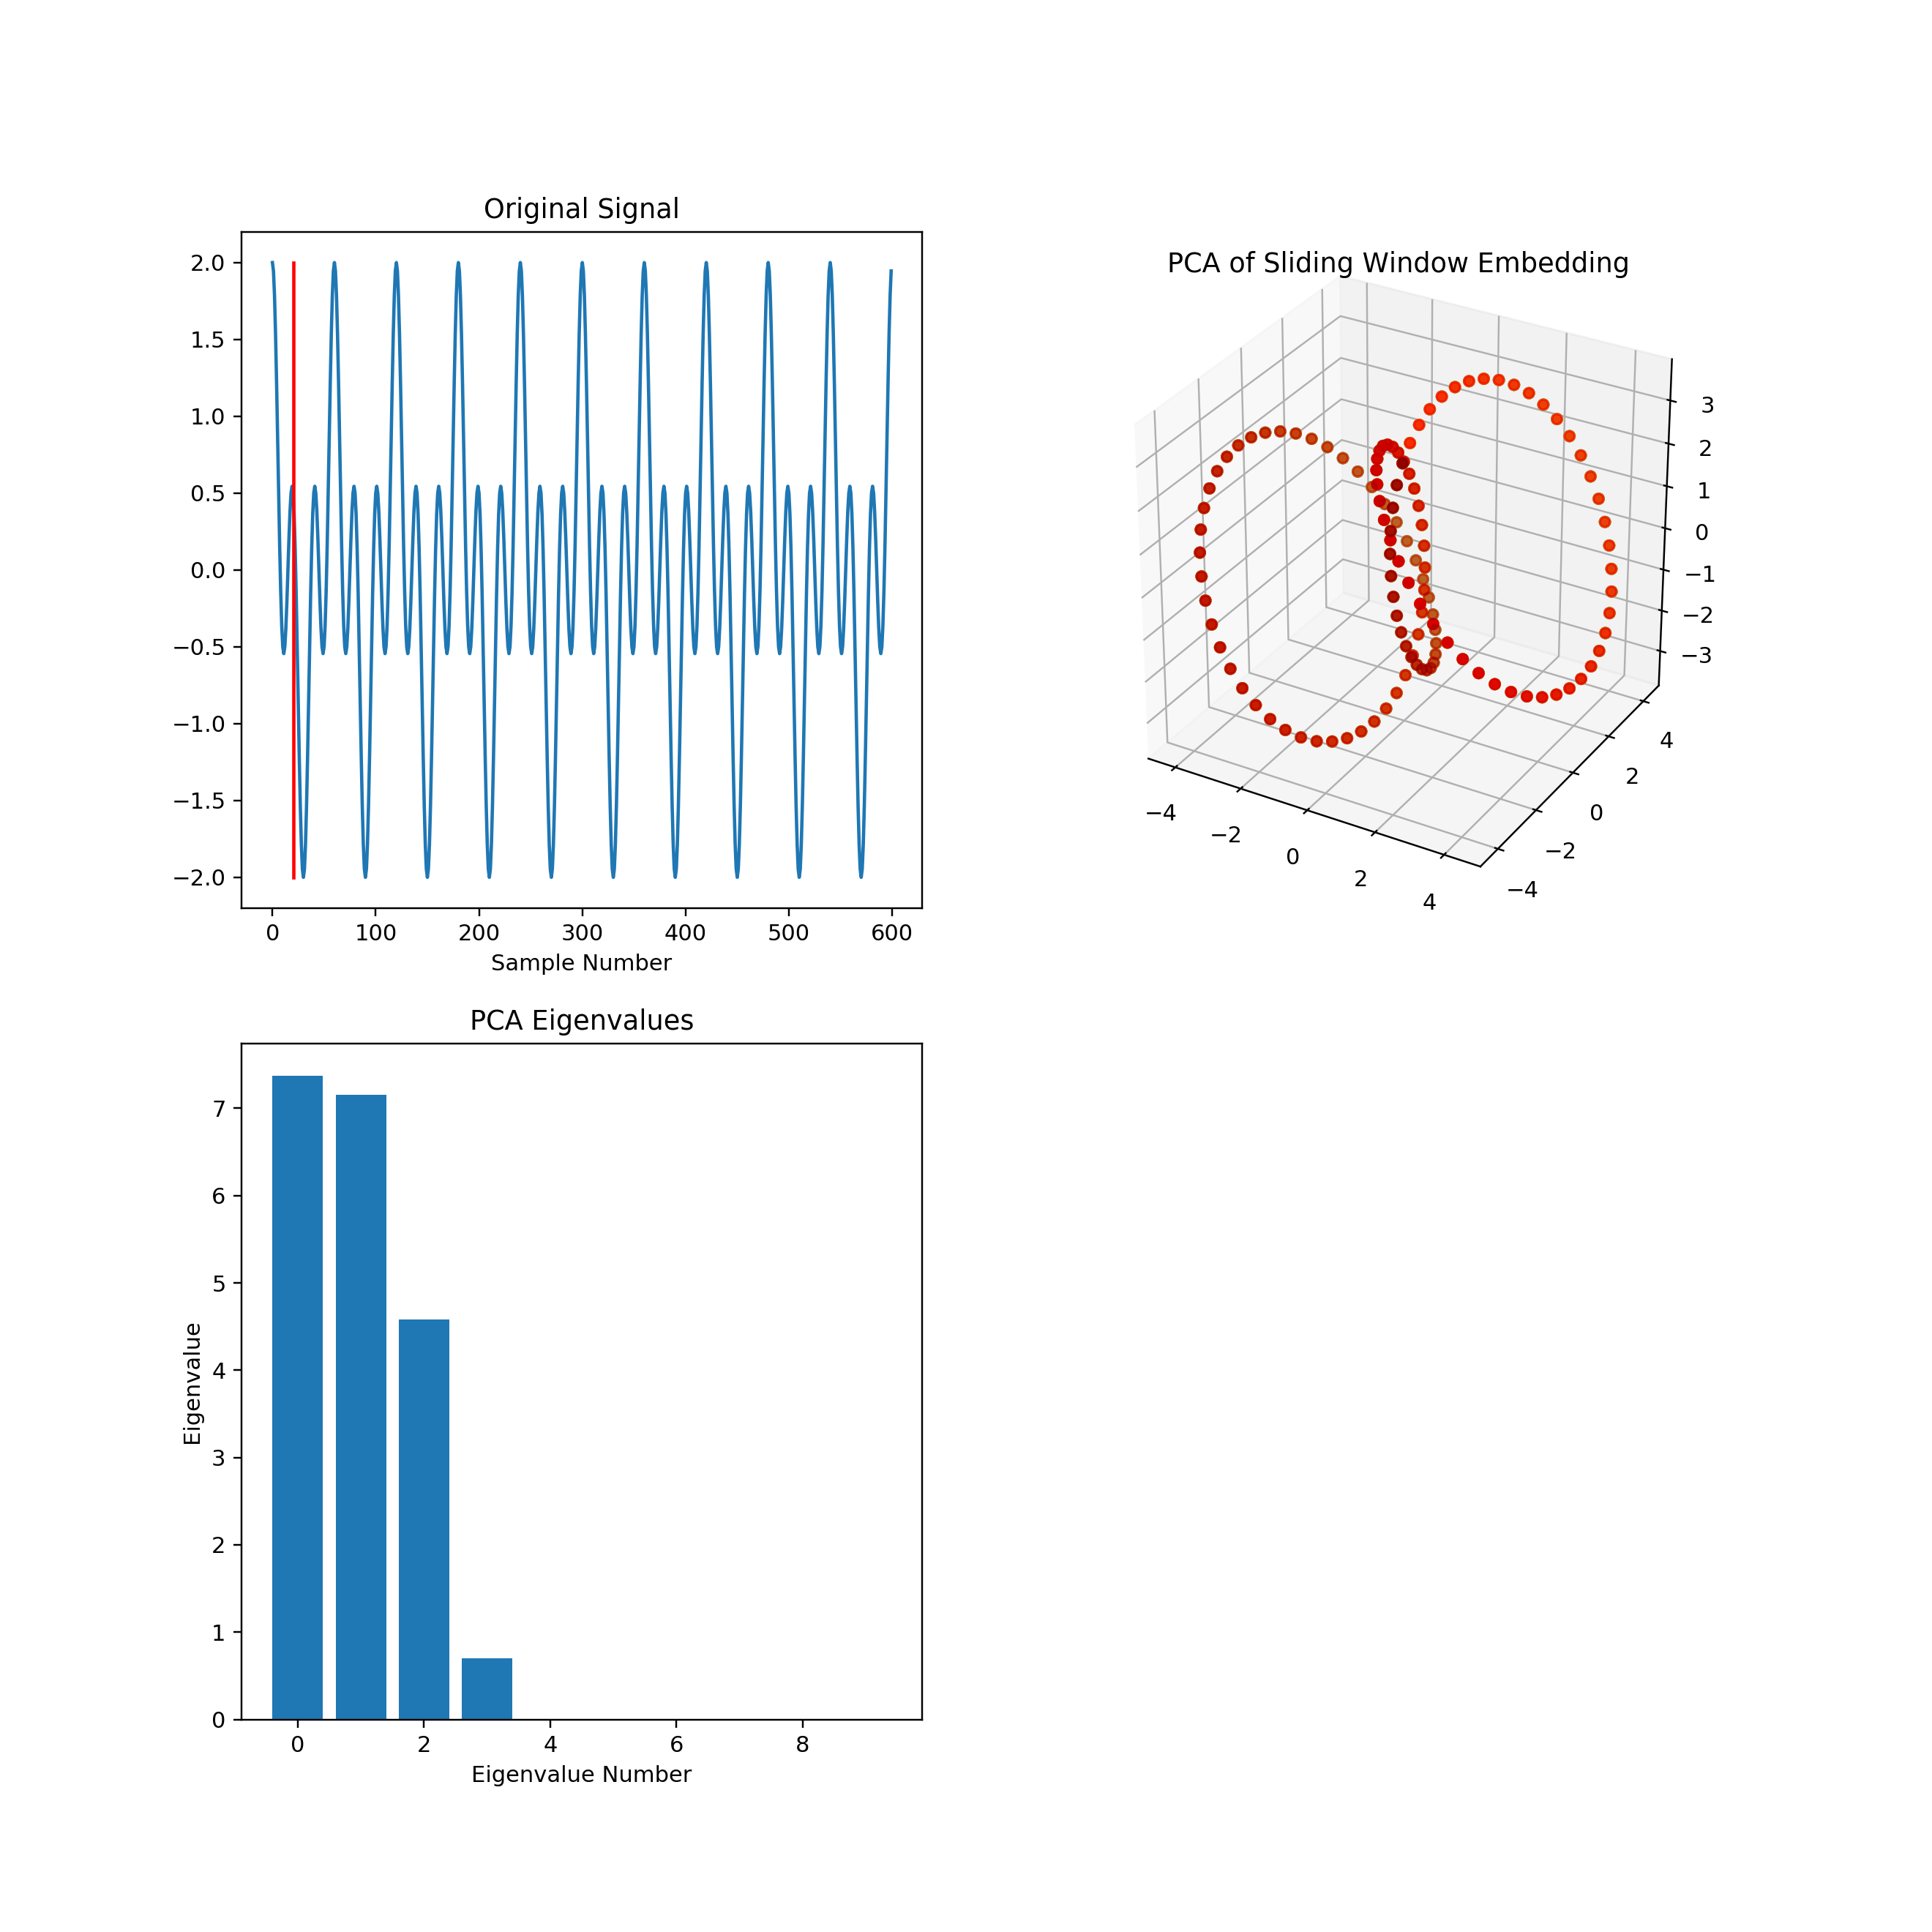

<Container object of 10 artists>

In [17]:
#Step 1: Setup the signal
T1 = 20 #The period of the first sine in number of samples
T2 = T1*3 #The period of the second sine in number of samples
NPeriods = 10 #How many periods to go through, relative to the second sinusoid
N = T2*NPeriods #The total number of samples
t = np.arange(N) #Time indices
x = np.cos(2*np.pi*(1.0/T1)*t) #The first sinusoid
x += np.cos(2*np.pi*(1.0/T2)*t) #The second sinusoid


#Step 2: Do a sliding window embedding
dim = 20
Tau = 1
dT = 0.5
X = getSlidingWindow(x, dim, Tau, dT)
extent = Tau*dim

#Step 3: Perform PCA down to 2D for visualization
pca = PCA(n_components = 10)
Y = pca.fit_transform(X)
eigs = pca.explained_variance_

#Step 4: Plot original signal and PCA of the embedding
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(221)
ax.plot(x)
#ax.hold(True)
ax.plot([extent, extent], [np.min(x), np.max(x)], 'r')
ax.set_title("Original Signal")
ax.set_xlabel("Sample Number")

c = plt.get_cmap('jet')
C = c(np.array(np.round(np.linspace(0, 255, Y.shape[0])), dtype=np.int32))
C = C[:, 0:3]
ax2 = fig.add_subplot(222, projection = '3d')
ax2.set_title("PCA of Sliding Window Embedding")
ax2.scatter(Y[:, 0], Y[:, 1], Y[:, 2], c=C)
ax2.set_aspect('equal', 'datalim')

ax3 = plt.subplot(2, 2, 3)
eigs = eigs[0:min(len(eigs), 10)]
ax3.bar(np.arange(len(eigs)), eigs)
ax3.set_xlabel("Eigenvalue Number")
ax3.set_ylabel("Eigenvalue")
ax3.set_title("PCA Eigenvalues")

plt.show()

<h2>Power Spectrum</h2><BR>

We saw above that for a rather subtle change in frequency changing the second sinusoid from harmonic to noncommensurate, there is a marked change in the geometry.  By contrast, the power spectral density functions are very close between the two, as shown below.  Hence, it appears that geometric tools are more appropriate for telling the difference between these two types of signals

<IPython.core.display.Javascript object>


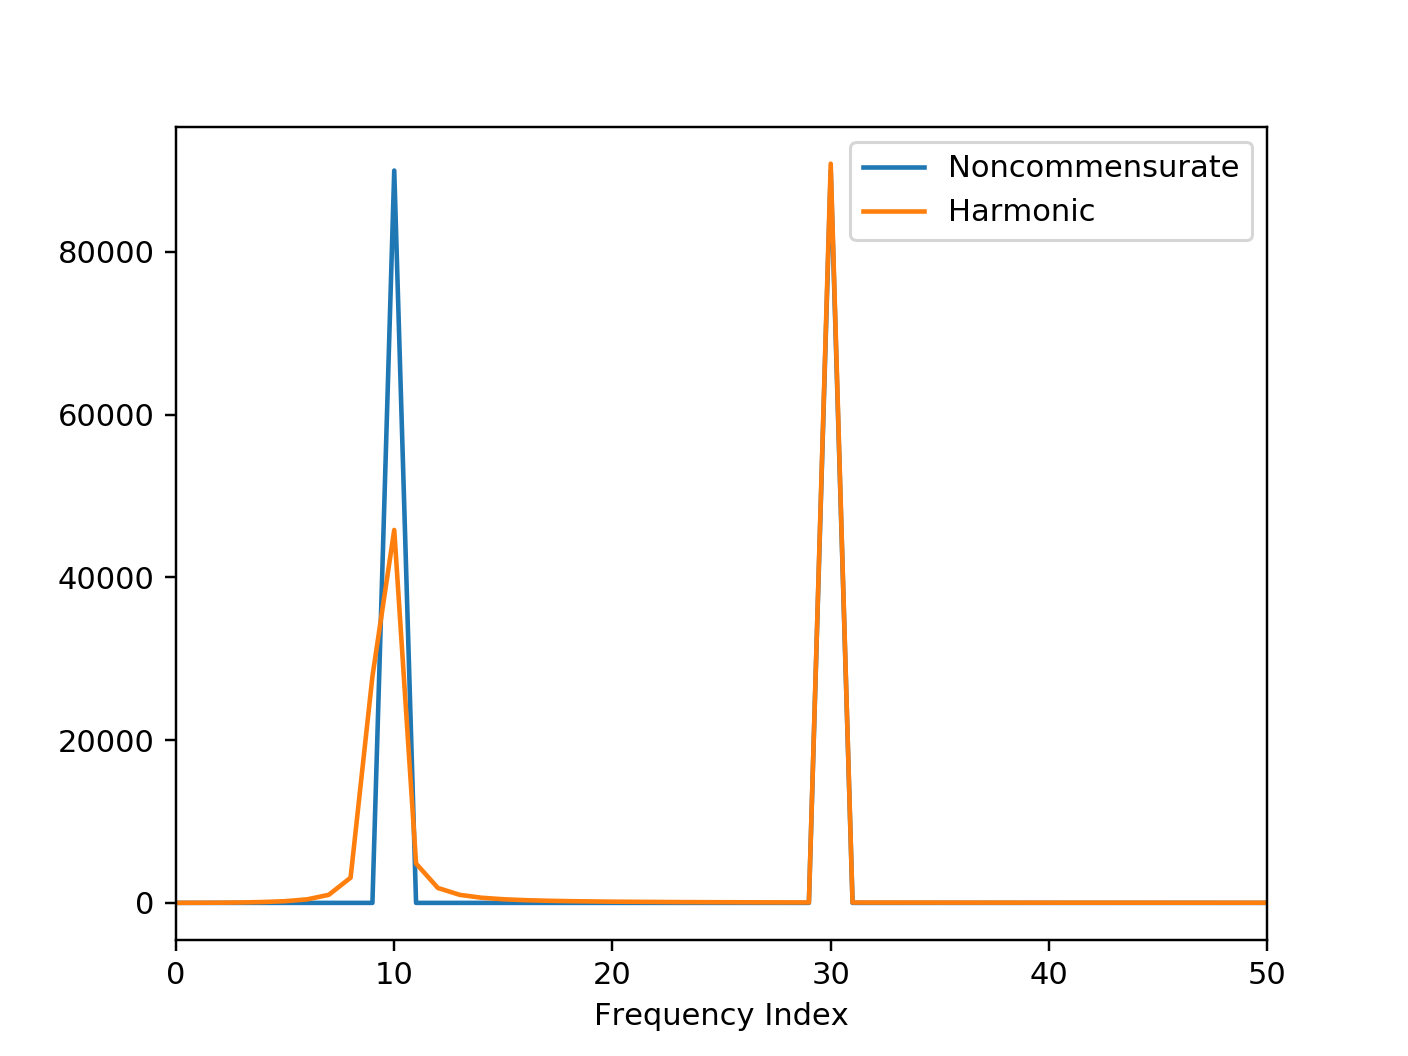

<IPython.core.display.Javascript object>


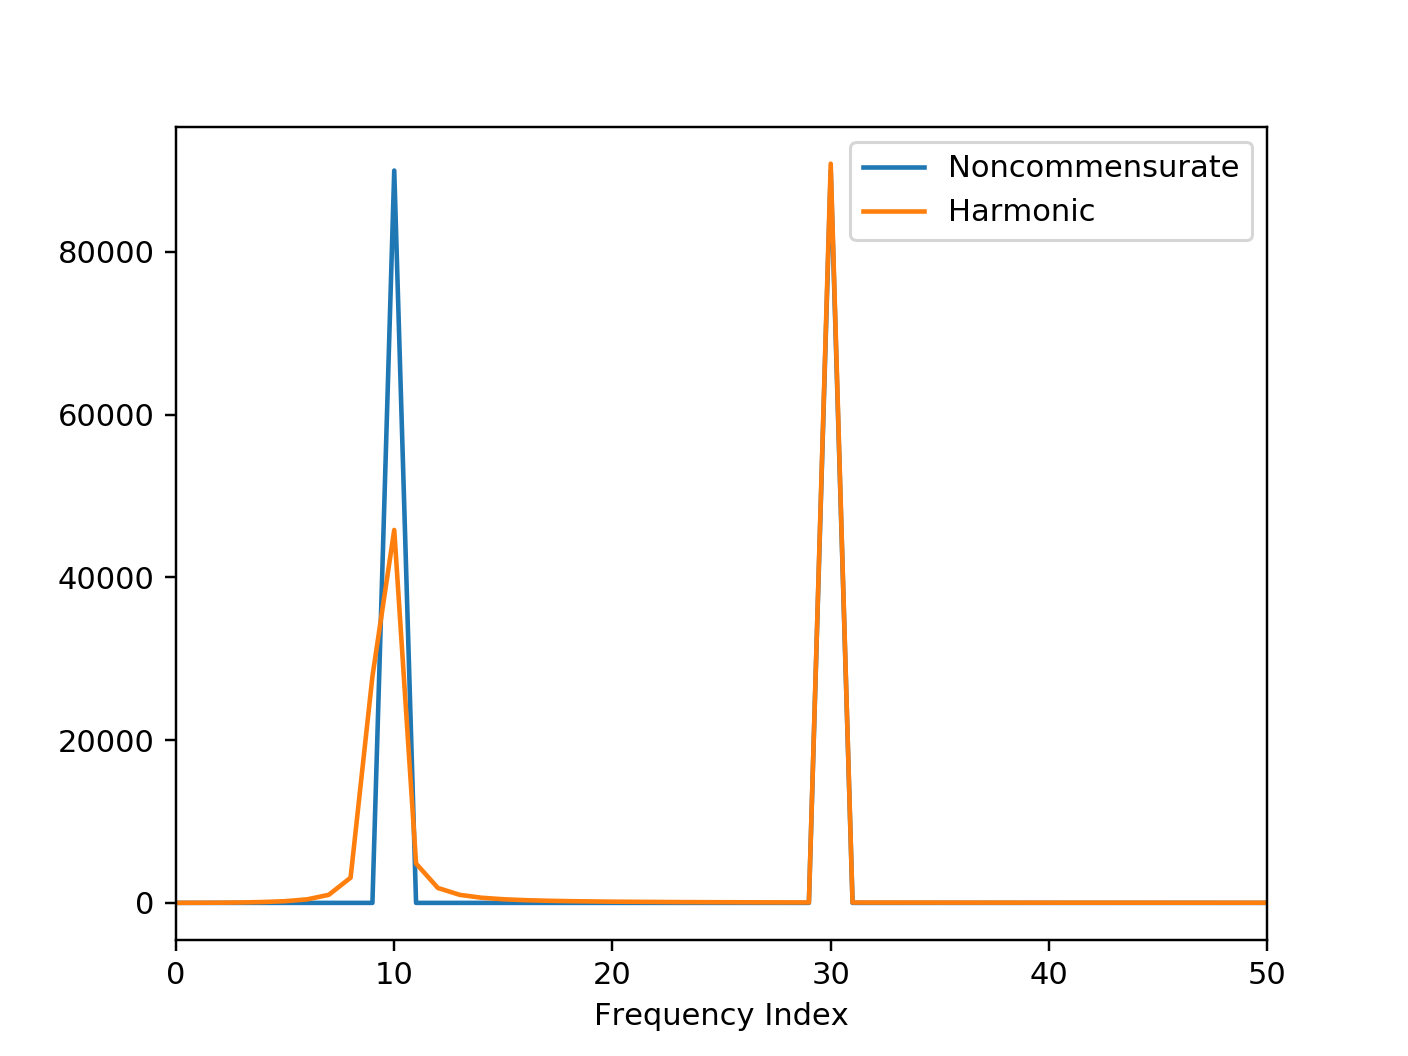

(0, 50)

In [18]:
T = 20 #The period of the first sine in number of samples
NPeriods = 10 #How many periods to go through, relative to the faster sinusoid
N = T*NPeriods*3 #The total number of samples
t = np.arange(N) #Time indices

#Make the harmonic signal cos(t) + cos(3t)
xH = np.cos(2*np.pi*(1.0/T)*t) + np.cos(2*np.pi*(1.0/(3*T)*t))
                                        
#Make the incommensurate signal cos(t) + cos(pi*t)
xNC = np.cos(2*np.pi*(1.0/T)*t) + np.cos(2*np.pi*(1.0/(np.pi*T)*t))

plt.figure()
P1 = np.abs(np.fft.fft(xH))**2
P2 = np.abs(np.fft.fft(xNC))**2
plt.plot(np.arange(len(P1)), P1)
#plt.hold(True)
plt.plot(np.arange(len(P2)), P2)
plt.xlabel("Frequency Index")
plt.legend({"Harmonic", "Noncommensurate"})
plt.xlim([0, 50])
plt.show()

<h1>Summary</h1>

<ul>
<li>Signals can be transformed into geometric objects via embeddings</li>
<li>Signal properties are captured by the geometry of the sliding window.  Periodicity corresponds to circularity, period length over window size corresponds to roundness, number of incommensurate frequencies corresponds to intrinsic dimension</li>
<li>The window extent is one of the most important parameters for determining roundness</li>
</ul>